In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor
import pandas as pd
pd.options.display.max_columns = None
from utils import create_time_series_splits
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet('../data/datasets_2023-2025_beta.parquet')
df.timestamp = pd.to_datetime(df.timestamp, unit = 's')

In [3]:
# df = pd.read_parquet('../data/datasets_2023-2025_1.parquet')
# df.timestamp = pd.to_datetime(df.timestamp, unit = 's')
# df['next_return'] = df.groupby('filename')['log_return'].shift(-1)

usd_coins = ["DAIUSD_720.parquet", "USDCUSD_720.parquet", "USDTUSD_720.parquet", "USTUSD_720.parquet"]
currencies = ["AUDUSD_720.parquet", "EURUSD_720.parquet", "GBPUSD_720.parquet"]
commodities = ['PAXGUSD_720.parquet']

df = df[~df.filename.isin(usd_coins + currencies + commodities)]
df['log_return'] = df.groupby('filename')['close'].transform(lambda x: np.log(x / x.shift(1)))
df['next_return'] = df.groupby('filename')['log_return'].shift(-1)
df = df[df['log_return'].notna()]
df = df[df['next_return'].notna()]

### One model across all names

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLPDrop(nn.Module):
    def __init__(self, in_dim, hidden_layer_sizes=[128, 64, 32], dropout_rate=0.2):
        super().__init__()
        layers = []
        last_size = in_dim
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_size = h
        layers.append(nn.Linear(last_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

def train_epoch(model, loader, loss_fn, opt):
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        opt.step()
        running += loss.item() * len(yb)
    return running / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        running += loss_fn(model(xb), yb).item() * len(yb)
    return running / len(loader.dataset)

In [14]:
def train_MLP_and_get_preds(df,
                            early_patience=10,
                            max_epochs=100,
                            learning_rate=1e-3,
                            weight_decay=1e-5,
                            batch_size=256,
                            model_size=[128, 64, 32],
                            dropout_rate=0.2):

    train_dfs, test_dfs = create_time_series_splits(df, date_column='timestamp')
    all_preds = []

    ctr = 0

    for train_df, test_df in zip(train_dfs, test_dfs):
        X_train = train_df.drop(columns=['timestamp', 'filename', 'next_return'])
        y_train = train_df['next_return']
        X_test  = test_df.drop(columns=['timestamp', 'filename', 'next_return'])
        y_test  = test_df['next_return']

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # split a small 10 % validation slice from training window
        val_frac = 0.10
        n_val = int(len(X_train_scaled) * val_frac)
        X_val_scaled, y_val = X_train_scaled[-n_val:], y_train.iloc[-n_val:]
        X_train_scaled, y_train = X_train_scaled[:-n_val], y_train.iloc[:-n_val]

        # DataLoaders
        train_loader = DataLoader(
            TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                        torch.tensor(y_train.values, dtype=torch.float32)),
            batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(
            TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                        torch.tensor(y_val.values, dtype=torch.float32)),
            batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(
            TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                        torch.tensor(y_test.values, dtype=torch.float32)),
            batch_size=batch_size, shuffle=False)

        # Model, loss, optimiser
        model = MLPDrop(in_dim=X_train.shape[1]).to(DEVICE)
        loss_fn = nn.MSELoss()
        opt     = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

        # Early-stopping loop
        best_val = float("inf")
        patience = 0
        for epoch in range(max_epochs):
            train_loss = train_epoch(model, train_loader, loss_fn, opt)
            val_loss   = eval_epoch(model, val_loader,   loss_fn)

            if val_loss < best_val - 1e-6:
                best_val = val_loss
                patience = 0
                best_state = model.state_dict()
            else:
                patience += 1
                if patience >= early_patience:
                    break

        model.load_state_dict(best_state)  # restore best

        # Predict on the test window
        model.eval()
        preds = []
        for xb, _ in test_loader:
            xb = xb.to(DEVICE)
            preds.append(model(xb).detach().cpu().numpy())
        preds = np.concatenate(preds)

        test_df = test_df.copy()
        test_df['pred'] = preds
        all_preds.append(test_df[['timestamp', 'filename', 'pred', 'next_return']])

        # if ctr == 0:
        #     break
        # ctr += 1
    all_preds_df = pd.concat(all_preds, ignore_index=True)
    return all_preds_df
    # all_preds_df.to_parquet('MLPRegressor_predictions_one_model.parquet', index=False)

In [26]:
all_preds_df = train_MLP_and_get_preds(df,
                                        early_patience=10,
                                        max_epochs=100,
                                        learning_rate=1e-3,
                                        weight_decay=1e-4,
                                        batch_size=512,
                                        model_size=[128, 64],
                                        dropout_rate=0.1)

In [30]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0244, MSE: 0.0015, R2: -0.0257, RMSE: 0.0382


In [28]:
all_preds_df.to_parquet('MLPRegressor_predictions_one_model.parquet', index=False)

In [31]:
all_preds_df.groupby('filename').apply(
    lambda x: pd.Series({
        'mse': mean_squared_error(x['next_return'], x['pred']),
        'mae': mean_absolute_error(x['next_return'], x['pred']),
        'r2': r2_score(x['next_return'], x['pred'])
    })
).reset_index().sort_values('r2')

,filename,mse,mae,r2
51,KILTUSD_720.parquet,0.001811,0.027870,-0.088792
86,TRXUSD_720.parquet,0.000196,0.009618,-0.057116
20,CHZUSD_720.parquet,0.001008,0.022272,-0.052816
31,EOSUSD_720.parquet,0.000755,0.018616,-0.050704
75,SANDUSD_720.parquet,0.001063,0.020867,-0.049432
...,...,...,...,...
70,POLISUSD_720.parquet,0.002313,0.035266,-0.005858
56,LPTUSD_720.parquet,0.002269,0.030044,-0.004634
15,BCHUSD_720.parquet,0.000987,0.020238,-0.001292
17,BSXUSD_720.parquet,0.003209,0.034517,0.004123


In [31]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0246, MSE: 0.0015, R2: -0.0511, RMSE: 0.0387


In [32]:
# plt
import matplotlib.pyplot as plt

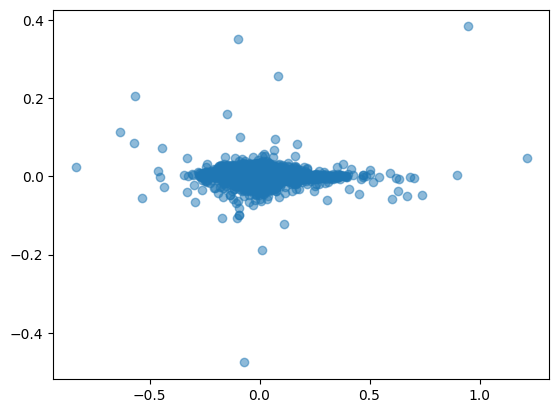

In [33]:
plt.scatter(all_preds_df['next_return'], all_preds_df['pred'], alpha=0.5)

In [34]:
all_preds_df.sort_values('pred')

,timestamp,filename,pred,next_return
86130,2024-09-22 12:00:00,KILTUSD_720.parquet,-0.475662,-0.071011
79994,2024-08-21 12:00:00,YFIUSD_720.parquet,-0.188032,0.011953
73898,2024-07-20 12:00:00,CQTUSD_720.parquet,-0.123097,0.108990
23279,2023-10-31 00:00:00,JUNOUSD_720.parquet,-0.107520,-0.171009
97514,2024-11-20 12:00:00,CQTUSD_720.parquet,-0.107197,-0.103990
...,...,...,...,...
97609,2024-11-21 00:00:00,CQTUSD_720.parquet,0.159544,-0.147325
73524,2024-07-18 12:00:00,CQTUSD_720.parquet,0.204075,-0.566395
73417,2024-07-18 00:00:00,CQTUSD_720.parquet,0.255572,0.084557
73610,2024-07-19 00:00:00,CQTUSD_720.parquet,0.350165,-0.100083


In [35]:
all_preds_df[(all_preds_df['filename'] == 'CQTUSD_720.parquet') & (all_preds_df['timestamp'] >= '2024-07-13')].sort_values('timestamp').head(20)

,timestamp,filename,pred,next_return
72458,2024-07-13 00:00:00,CQTUSD_720.parquet,0.421976,0.169559
72560,2024-07-13 12:00:00,CQTUSD_720.parquet,0.331784,-0.155171
72656,2024-07-14 00:00:00,CQTUSD_720.parquet,0.198960,-0.040078
72746,2024-07-14 12:00:00,CQTUSD_720.parquet,0.296804,-0.109914
72841,2024-07-15 00:00:00,CQTUSD_720.parquet,0.232670,-0.331505
72948,2024-07-15 12:00:00,CQTUSD_720.parquet,0.260539,-0.047346
73034,2024-07-16 00:00:00,CQTUSD_720.parquet,0.279166,-0.442506
73129,2024-07-16 12:00:00,CQTUSD_720.parquet,0.242634,0.063949
73225,2024-07-17 00:00:00,CQTUSD_720.parquet,0.263265,-0.568505
73322,2024-07-17 12:00:00,CQTUSD_720.parquet,0.110583,-0.632523


### Old

dfs = []
in_folder_path = "../data/Kraken_features/"
for file in os.listdir(in_folder_path):
    cur_df = pd.read_parquet(in_folder_path + file)
    cur_df['filename'] = file
    dfs.append(cur_df)
df = pd.concat(dfs)
df.reset_index(inplace=True)

In [ ]:
hyperparam_grid = {
    "model_size"    : [[128, 64], [128, 64, 32], [256, 128, 64], [64, 32, 16], [64, 32]],
    "dropout_rate"  : [0.10, 0.20, 0.30],
    "learning_rate" : [1e-3, 5e-4, 1e-4],
    "weight_decay"  : [1e-4, 1e-5, 1e-6],
    "batch_size"    : [128, 256, 512],
}

baseline = {
    "model_size"    : hyperparam_grid["model_size"][0],
    "dropout_rate"  : hyperparam_grid["dropout_rate"][0],
    "learning_rate" : hyperparam_grid["learning_rate"][0],
    "weight_decay"  : hyperparam_grid["weight_decay"][0],
    "batch_size"    : hyperparam_grid["batch_size"][0],
}

records = []

for param_name, values in hyperparam_grid.items():
    for v in values:
        # start from baseline and overwrite just this one hyperparam
        params = baseline.copy()
        params[param_name] = v

        # train & predict using the current set of hyperparameters
        all_preds_df = train_MLP_and_get_preds(
            df,
            early_patience=10,
            max_epochs=100,
            learning_rate=params["learning_rate"],
            weight_decay=params["weight_decay"],
            model_size=params["model_size"],
            dropout_rate=params["dropout_rate"],
            batch_size=params["batch_size"],
        )

        # compute metrics
        y_true = all_preds_df["next_return"]
        y_pred = all_preds_df["pred"]
        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        rmse = np.sqrt(mse)

        # save one row per run
        record = {
            "model_size"    : params["model_size"],
            "dropout_rate"  : params["dropout_rate"],
            "learning_rate" : params["learning_rate"],
            "weight_decay"  : params["weight_decay"],
            "batch_size"    : params["batch_size"],
            "mae"           : mae,
            "mse"           : mse,
            "r2"            : r2,
            "rmse"          : rmse,
        }
        records.append(record)

hyperparam_results = pd.DataFrame.from_records(records)

In [ ]:
hyperparam_results.sort_values('r2')

,model_size,dropout_rate,learning_rate,weight_decay,batch_size,mae,mse,r2,rmse
12,"[128, 64]",0.1,0.0010,0.000010,128,0.024778,0.001674,-0.176422,0.040916
6,"[128, 64]",0.2,0.0010,0.000100,128,0.024669,0.001652,-0.160842,0.040644
2,"[256, 128, 64]",0.1,0.0010,0.000100,128,0.024500,0.001573,-0.105387,0.039662
15,"[128, 64]",0.1,0.0010,0.000100,256,0.024576,0.001554,-0.092285,0.039426
8,"[128, 64]",0.1,0.0010,0.000100,128,0.024606,0.001553,-0.091260,0.039407
11,"[128, 64]",0.1,0.0010,0.000100,128,0.024556,0.001552,-0.090735,0.039398
4,"[64, 32]",0.1,0.0010,0.000100,128,0.024593,0.001546,-0.086538,0.039322
9,"[128, 64]",0.1,0.0005,0.000100,128,0.024622,0.001543,-0.084532,0.039286
14,"[128, 64]",0.1,0.0010,0.000100,128,0.024573,0.001541,-0.083031,0.039259
0,"[128, 64]",0.1,0.0010,0.000100,128,0.024491,0.001522,-0.069725,0.039017
